This is an example of how to use ABC-SysBio to do model comparison using SBML models, without using the ``run-abc-sysbio`` commandline script.

There are examples of how to use ABC-SysBio without using SBML in the ``examples/standalone`` directory.

In [1]:
import numpy
import numpy as np
from abcsysbio import abcsmc
from abcsysbio import input_output
from abcsysbio import kernels
from abcsysbio import abcModel
from abcsysbio import EpsilonSchedule
from abcsysbio import euclidian

from abcsysbio.KernelType import KernelType
from abcsysbio.PriorType import PriorType
from abcsysbio.Prior import Prior

import matplotlib
%matplotlib inline
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import re

%load_ext autoreload
%autoreload 2
matplotlib.rcParams['savefig.dpi'] = 3 * matplotlib.rcParams['savefig.dpi']

In [2]:
class Data:
    def __init__(self, times, values):
        self.timepoints = times
        self.values = values


In [3]:
# Settings from input_file_SIR.xml
nparticles = 200

kernel = KernelType.component_wise_uniform  #check out kernalType.py

modelnumber = 3
restart = False

# epsilon = [[20, 15, 10, 5, 3, 2.5, 2, 1.7, 1.5, 1,2, 1]]
epsilon = [[20, 15, 10, 5, 3, 2.5, 2, 1.7]] # use a truncated epsilon sequence so example runs faster

beta = 1
dt = 1
rtol = 1e-4
atol = 1e-6

logp = False

times = [0.0, 0.6, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
values = [[ 20.     ,  10.     ,   0.     ],
       [  0.12313,  13.16813,   9.42344],
       [  0.12102,   7.17251,  11.18957],
       [  0.09898,   2.36466,  10.0365 ],
       [  0.37887,   0.92019,   6.87117],
       [  1.00661,   0.61958,   4.44955],
       [  1.20135,   0.17449,   3.01271],
       [  1.46433,   0.28039,   1.76431],
       [  1.37789,   0.0985 ,   1.28868],
       [  1.57073,   0.03343,   0.81813],
       [  1.4647 ,   0.28544,   0.52111],
       [  1.24719,   0.10138,   0.22746],
       [  1.56065,   0.21671,   0.19627]]

data = Data(times, np.array(values))

In [4]:
# Run-time settings
debug = 1 #or 0 or 2 (higher the more details)

timing = False
fname = "results_"  # outfolder

randomSeed = None #or an integer
if randomSeed is not None:
    print "#### Seeding random number generator : ", randomSeed
    numpy.random.seed(randomSeed)

modelKernel = 0.7
nbatch = 10



In [5]:
# Models and Priors as specified in inpit_file_SIR.xml

from cudasim.solvers.python import model_py
from cudasim import ParseAndWrite

prior1 = [Prior(PriorType.constant, value=1.0), 
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0)]    

ic_prior1 = [Prior(PriorType.constant, value=20.0), 
             Prior(PriorType.constant, value=10.0), 
             Prior(PriorType.constant, value=0.0)] 

ParseAndWrite.parse_and_write(["SIRModel1.xml", "SIRModel2.xml", "SIRModel3.xml"], ["Python", "Python", "Python"], ["SIRModel1", "SIRModel2", "SIRModel3"], input_path="",
                                          output_path="")
             
model1 = model_py.Model(name="SIRModel1", nspecies=3,
                           nparameters=5,
                           prior=prior1, x0prior=ic_prior1,
                           source="SIRModel1", integration="ODE", fit=None,
                           dt=dt, atol=atol, rtol=rtol, logp=logp)


prior2 = [Prior(PriorType.constant, value=1.0), 
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=10.0)]    

ic_prior2 = [Prior(PriorType.constant, value=20.0), 
             Prior(PriorType.constant, value=0.0), 
             Prior(PriorType.constant, value=10.0), 
             Prior(PriorType.constant, value=0.0)]

model2 = model_py.Model(name="SIRModel2", nspecies=4,
                           nparameters=6,
                           prior=prior2, x0prior=ic_prior2,
                           source="SIRModel2", integration="ODE", 
                           fit=['sample_points[:,0]', 'sample_points[:,2]', 'sample_points[:,3]'],
                           dt=dt, atol=atol, rtol=rtol, logp=logp)



prior3 = [Prior(PriorType.constant, value=1.0), 
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=5.0),
          Prior(PriorType.uniform, lower_bound=0.0, upper_bound=10.0)]    

ic_prior3 = [Prior(PriorType.constant, value=20.0), 
             Prior(PriorType.constant, value=10.0), 
             Prior(PriorType.constant, value=0.0)]
             
model3 = model_py.Model(name="SIRModel3", nspecies=3,
                           nparameters=6,
                           prior=prior3, x0prior=ic_prior3,
                           source="SIRModel3", integration="ODE", fit=None,
                           dt=dt, atol=atol, rtol=rtol, logp=logp)

models = [model1, model2, model3]
modelprior = [1 / float(modelnumber)] * modelnumber


Looking for delay
Looking for delay
Looking for delay


In [18]:
# This a magic iPython command that will delete the results folder if it already exists
!rm -r _results_/

In [19]:
fname = '_results_'
pickling = True
io = input_output.InputOutput(fname, restart, False, False)
io.create_output_folders(["SIRModel1","SIRModel2", "SIRModel3"], pickling, True, False)


In [20]:
abcSmcInstance = abcsmc.Abcsmc(models=models,
                               nparticles=nparticles,
                               modelprior=modelprior,
                               data=data,
                               beta=beta,
                               nbatch=nbatch,
                               model_kernel=modelKernel,
                               debug=debug,
                               timing=timing,
                               distancefn=euclidian.euclidian_distance,
                               kernel_type=kernel,
                               kernelfn=kernels.get_kernel,
                               kernelpdffn=kernels.get_parameter_kernel_pdf,
                               perturbfn=kernels.perturb_particle)


### Found special kernel case 1 for model  0 ###
### Found special kernel case 1 for model  1 ###
### Found special kernel case 1 for model  2 ###


In [21]:
allResults = abcSmcInstance.run_fixed_schedule([[20], [15], [10], [5], [3], [2.5], [2], [1.7]], io, store_all_results=True)

### iteration:1, eps=['20.00'], sampled=705, accepted=28.4%
	 model marginals                  : [0.3200000000000002, 0.39000000000000024, 0.29000000000000015]
### iteration:2, eps=['15.00'], sampled=947, accepted=21.1%
	 model marginals                  : [0.302754341906039, 0.37311850274656905, 0.32412715534739212]
### iteration:3, eps=['10.00'], sampled=2302, accepted=8.7%
	 model marginals                  : [0.40599114946304105, 0.5097615679505263, 0.084247282586433159]
### iteration:4, eps=['5.00'], sampled=7682, accepted=2.6%
	 model marginals                  : [0.46076695949531554, 0.52883698286383229, 0.010396057640852687]
### iteration:5, eps=['3.00'], sampled=6989, accepted=2.9%
	 model marginals                  : [0.5643210223046855, 0.4356789776953145, 0]
	 dead models                      : [2]
### iteration:6, eps=['2.50'], sampled=2156, accepted=9.3%
	 model marginals                  : [0.55446129923240262, 0.44553870076759733, 0]
	 dead models                      :

# Plotting results

In [22]:
from abcsysbio import plotter

Let's plot the model marginal probabilities:

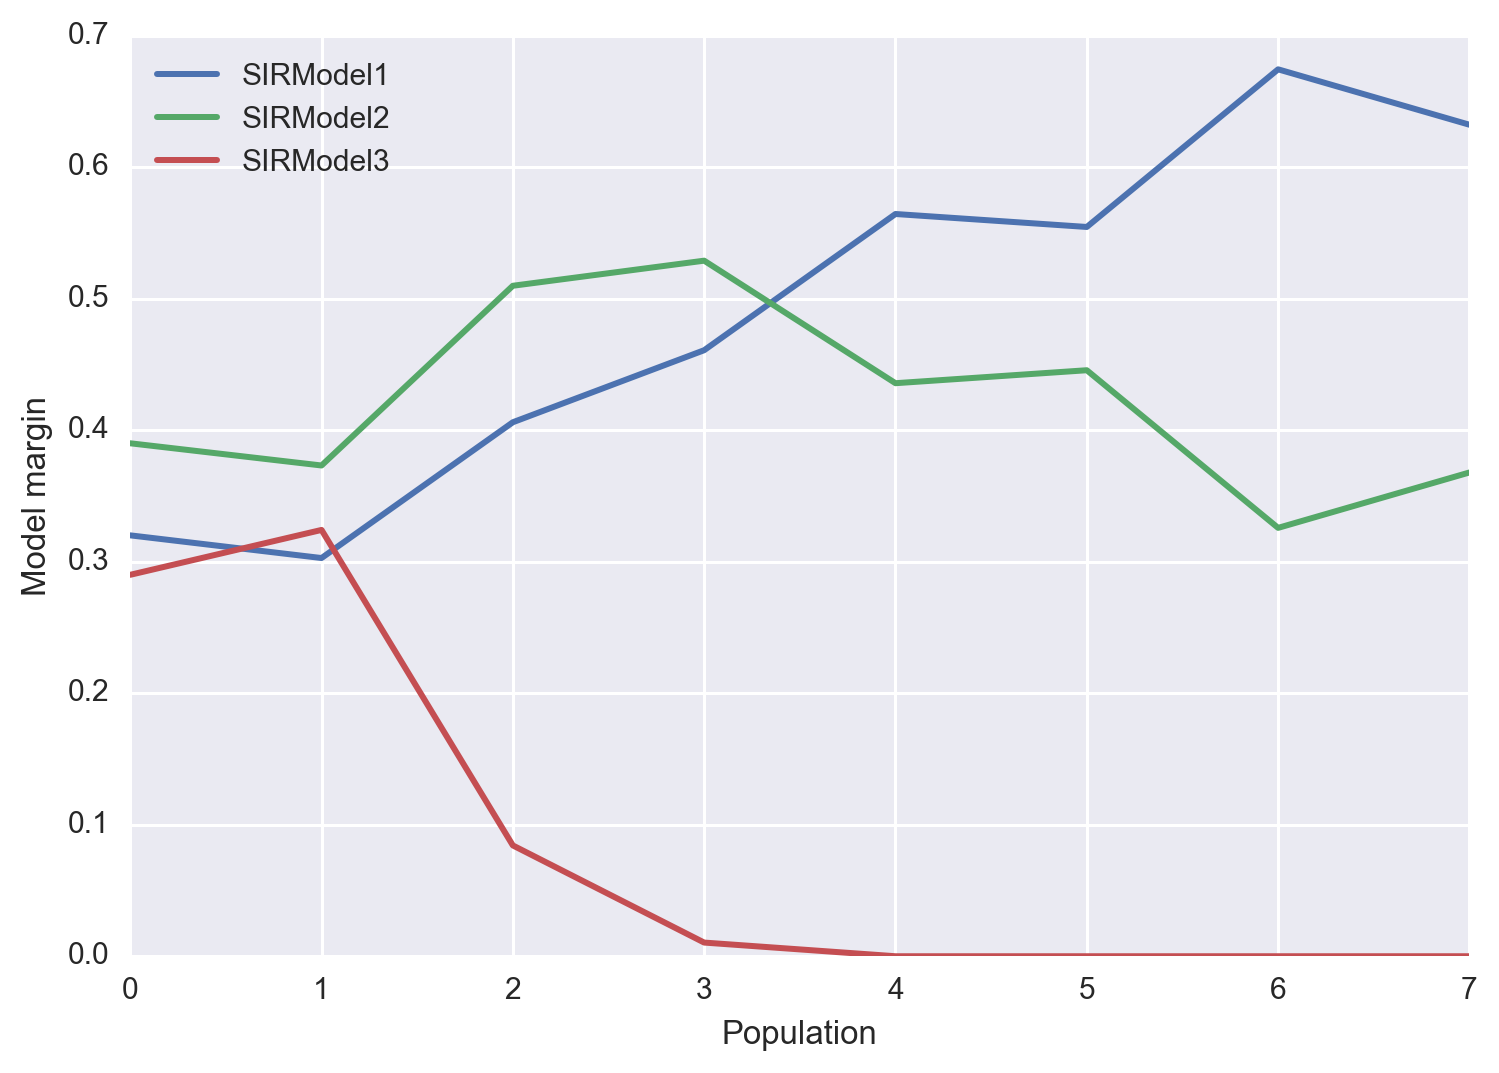

In [23]:
plotter.modelMarginsByPopulation(allResults, models)

Lets's do a pairplot of the samples at each iteration.

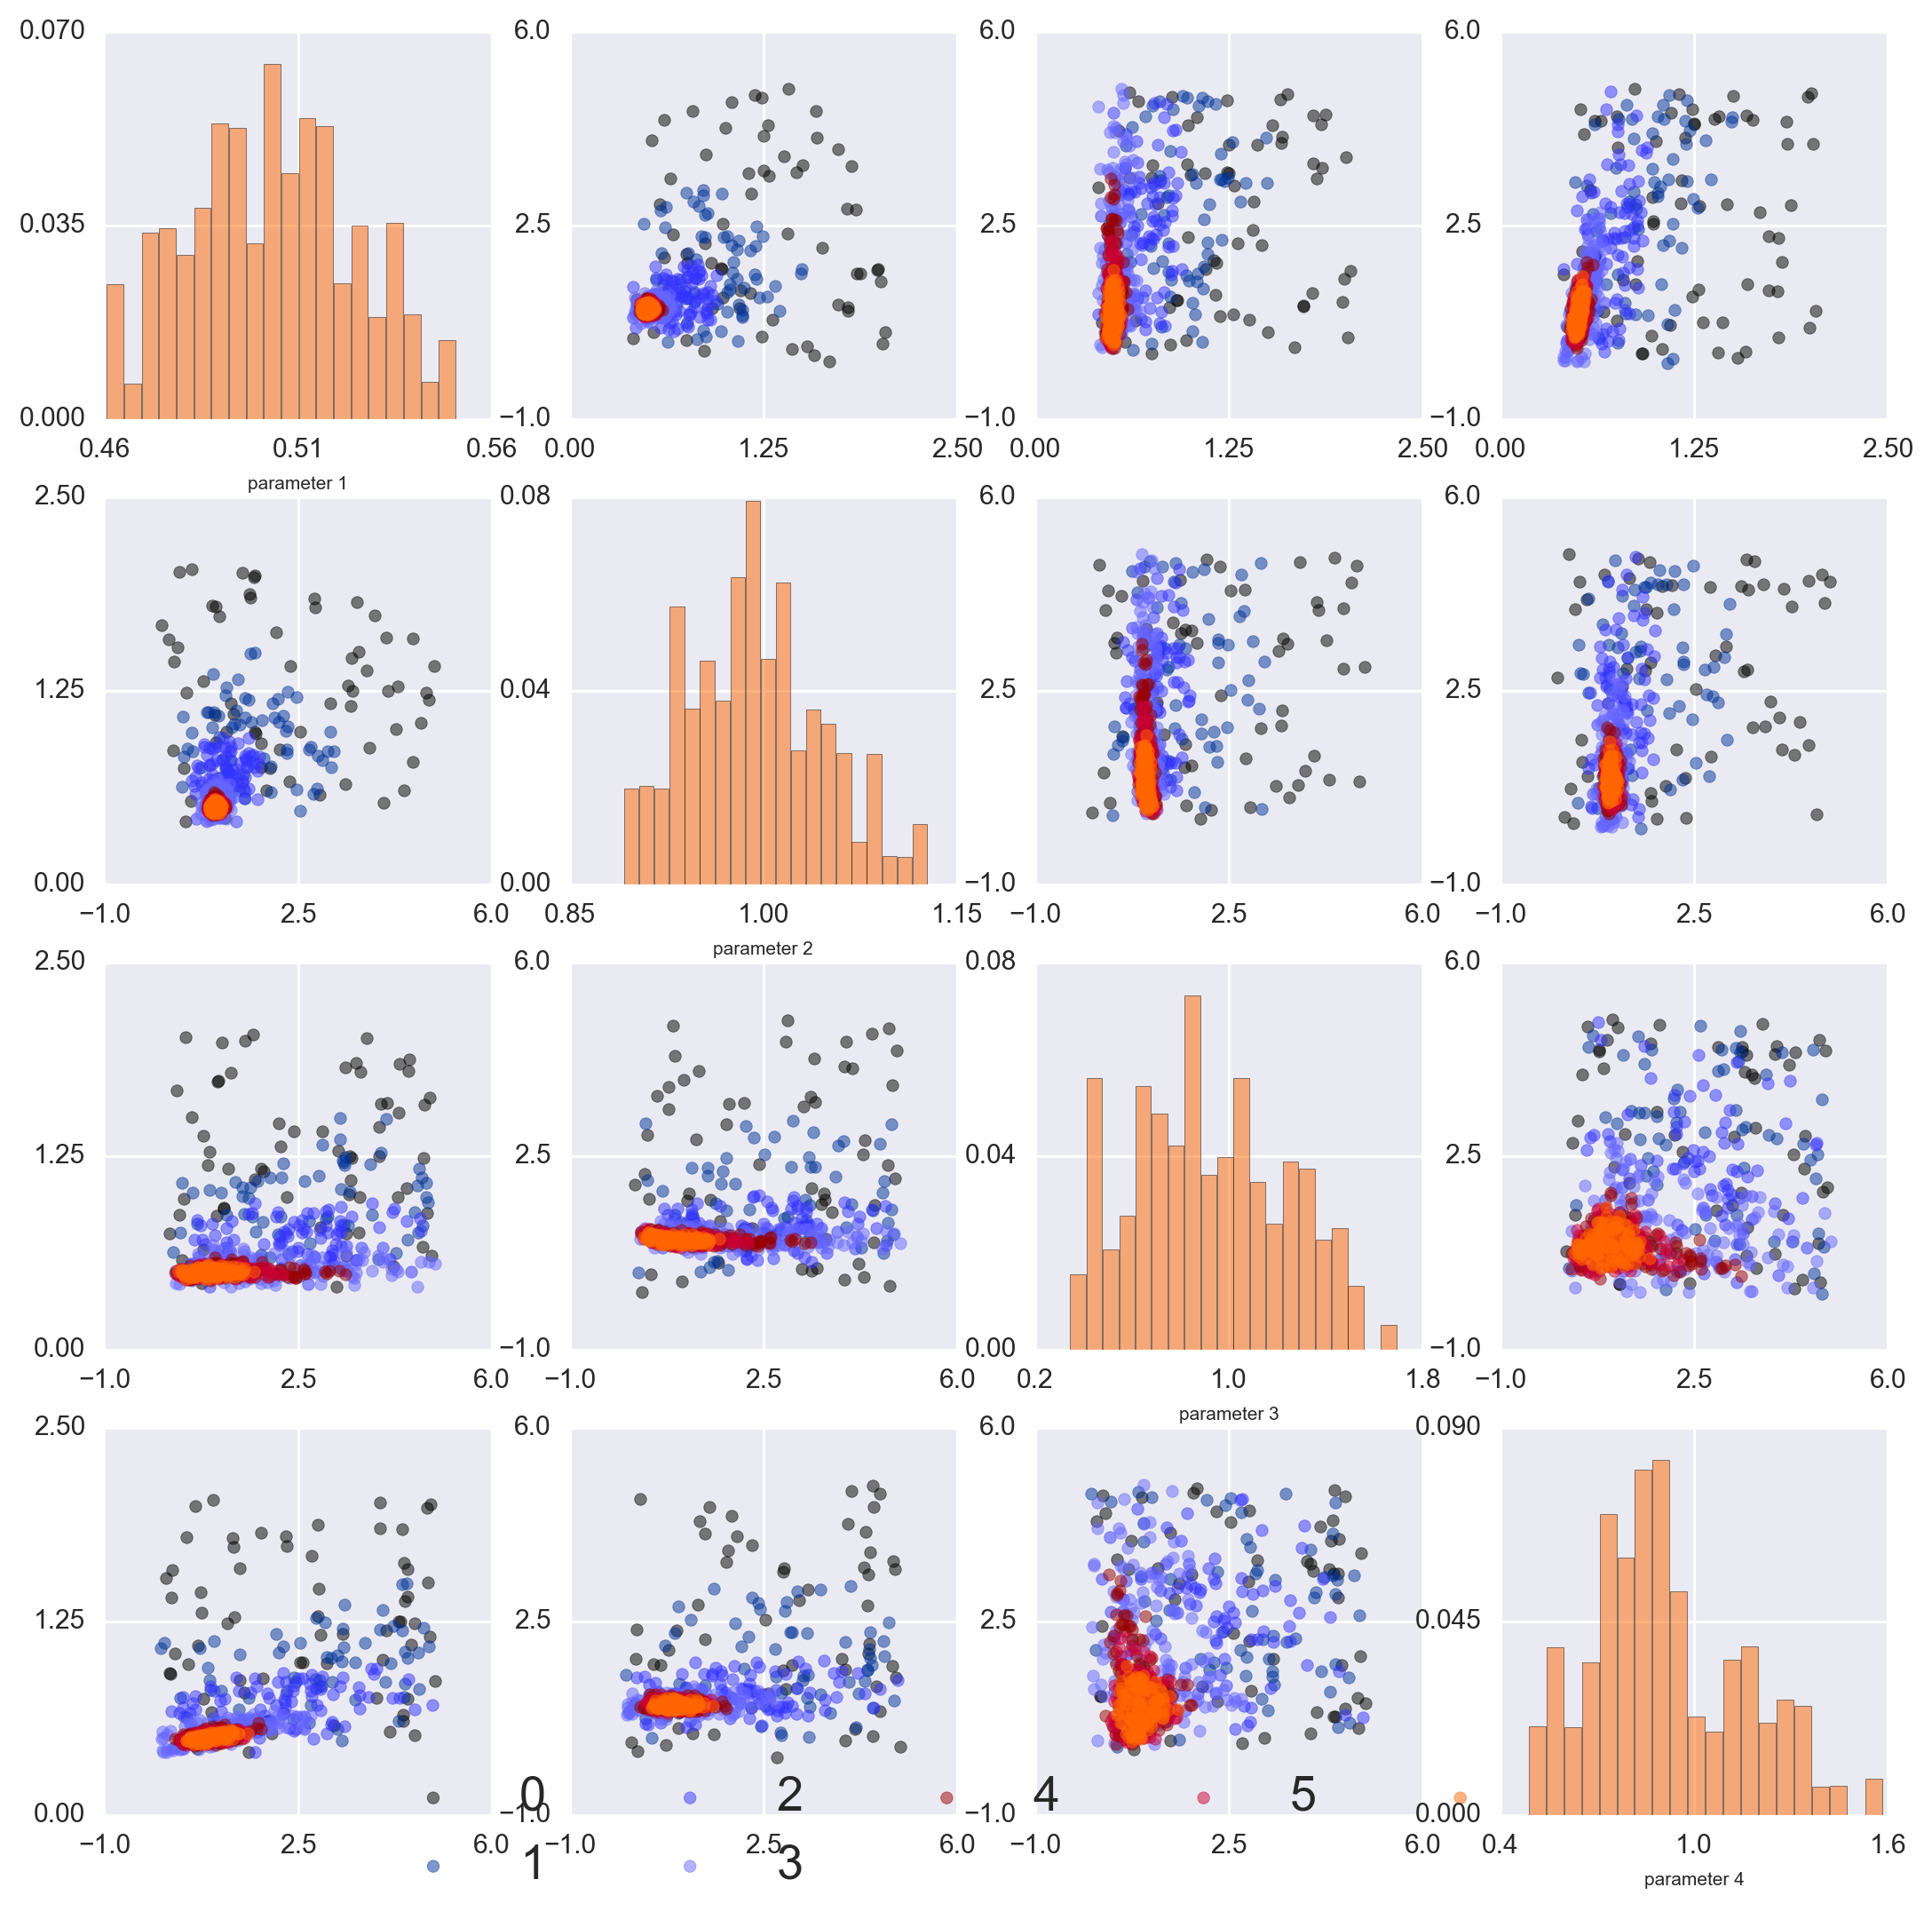

In [25]:
plotter.doPairPlot(allResults, 0, range(0, len(epsilon[0])-1), models)